<a href="https://colab.research.google.com/github/coreygoavec/Presentation-2/blob/main/Presentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Presentation 2
### Why are customers leaving their credit card services and going else where.

## $\color{red}{\text{Import Required Packages}}$

In [35]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

## $\color{red}{\text{Importing Data}}$

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
%cd '/content/drive/MyDrive/DS 4510/Data'
churn_df = pd.read_excel('churn.xlsx', sheet_name = "BankChurners")

/content/drive/MyDrive/DS 4510/Data


### $\color{blue}{\text{Separating Numeric and Categorical Data}}$

In [71]:
# Numeric component of HR dataset
churn_df_num = churn_df.select_dtypes(include = np.number) # Selecting only the numeric data of the dataset // select data types and including only numbers
# churn_df_num.head()

# Categorical component of HR dataset
churn_df_cat = churn_df.select_dtypes(exclude = np.number) # Selecting only the categorical data // select data types and exluding numeric
# churn_df_cat.head()

## $\color{red}{\text{Data Transformation}}$

### $\color{blue}{\text{Missing Value Analysis}}$

- Checking missing values in the data

In [38]:
# Function to compute missing values
def percent_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

# Using the function
percent_missing(churn_df).head()

Total_Revolving_Bal    0.243902
Education_Level        0.149995
Income_Category        0.109805
Marital_Status         0.073961
Credit_Limit           0.003456
dtype: float64

### $\color{blue}{\text{Imputation}}$

In [132]:
# Function to do conditional deletion

def semi_listwise(data, nan_percent):
    d1 = data.isnull().sum().divide(len(data)).sort_values(ascending=False)
    culprit_vars = []
    for i in range(len(d1.values)):
        if(d1.values[i] >= nan_percent):
            culprit_vars.append(d1.index[i])
    return data[data.columns.difference(culprit_vars)]

In [133]:
delCol15_num = semi_listwise(churn_df_num, 0.15) # Deleting all columns with 15% missing data

# Check if deletion worked
print(churn_df.shape) # Printing shape of original data
print(delCol15_num.shape) # Printing shape of deleted columns

(10127, 21)
(10127, 14)


In [134]:
# Find the median
col_med = delCol15_num.median() # calculating the median for each column
# print(col_med) # Printing the medians for each column

# Now inpute missing data with the median
churn_df_full = delCol15_num.fillna(col_med) # Filling in missing data with the median for each column

# Now check if data is missing
percent_missing(churn_df_full)

Age                      0.0
Avg_Open_To_Buy          0.0
Avg_Utilization_Ratio    0.0
Client_ID                0.0
Contacts_In12Mon         0.0
Credit_Limit             0.0
Dependent_Count          0.0
Inactive_In12Mon         0.0
Months_With_Bank         0.0
Products_By_Clients      0.0
Total_Amt_Chng_Q4_Q1     0.0
Total_Ct_Chng_Q4_Q1      0.0
Total_Trans_Amt          0.0
Total_Trans_Ct           0.0
dtype: float64

### $\color{blue}{\text{Multicollinearity}}$

**Multicollinearity** occurs when variables have similar information
- Variables with a correlation greater than 0.70 are considered to have similar information

In [135]:
# !pip install dython
from dython.nominal import associations
import seaborn as sns

def corrPlot(data):

  # Use "associations" function to compute correlation between all variables
  corr_matrix = associations(dataset=data, compute_only=True)['corr']

  # Mask the upper triangle of correlation heatmap
  mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

  # Plotting correlation heatmap
  plt.figure(figsize=(12, 8))
  sns.heatmap(corr_matrix, annot=True, mask=mask_upper, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
  plt.show()

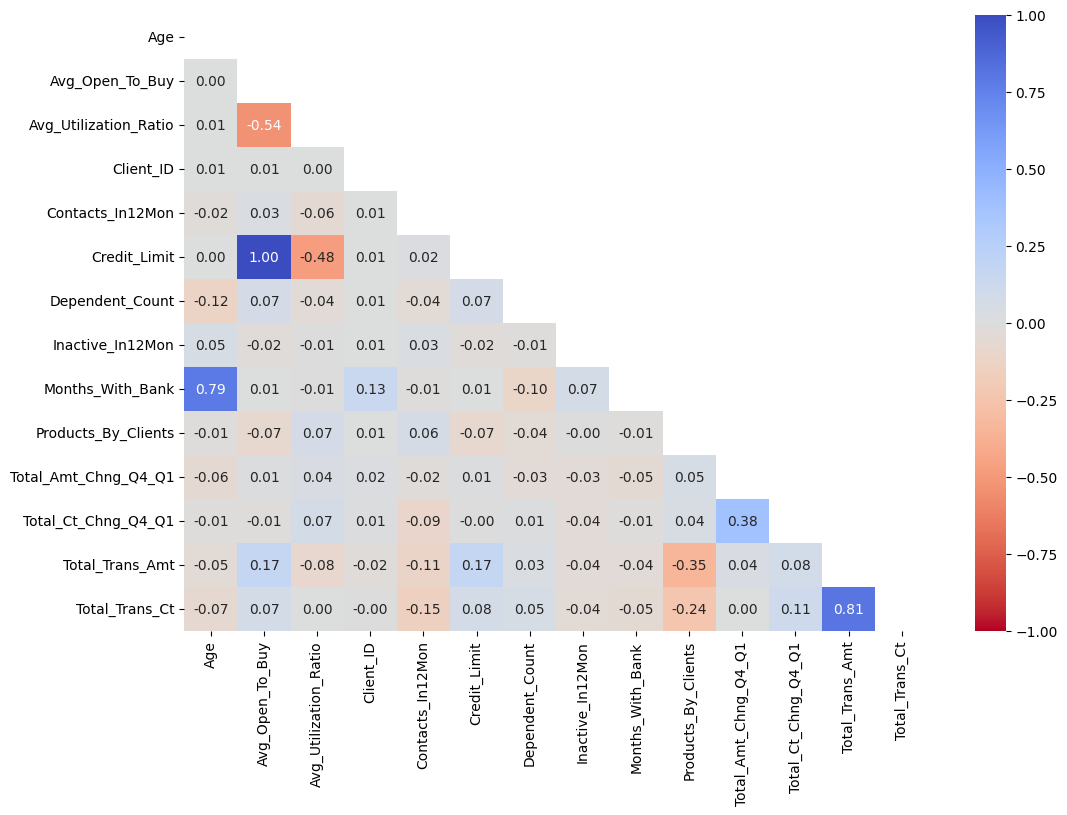

In [136]:
# Use function to plot correlation heatmap
corrPlot(churn_df_full)

### $\color{blue}{\text{Removing Colinear Variables}}$
- If correlation between variables are greater than 0.7 (70%), one of the variables should be removed.

In [137]:
'''
This function drops highly correlated variables given a threshold.
It drops the variable with smaller variance
'''

def drop_highly_correlated(data, threshold):
    cor_matrix = data.corr().abs()
    sol = (cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))).unstack().dropna()

    to_drop=[]
    for i in range(len(sol[sol > threshold].index.tolist())):
        var1 = sol[sol >= threshold].index.tolist()[i][0]
        var2 = sol[sol >= threshold].index.tolist()[i][1]

        if(data[var1].var() < data[var2].var()): to_drop.append(var1)
        else: to_drop.append(var2)

    dropped_vars = list(set(to_drop))
    return dropped_vars, data.drop(dropped_vars, axis=1)

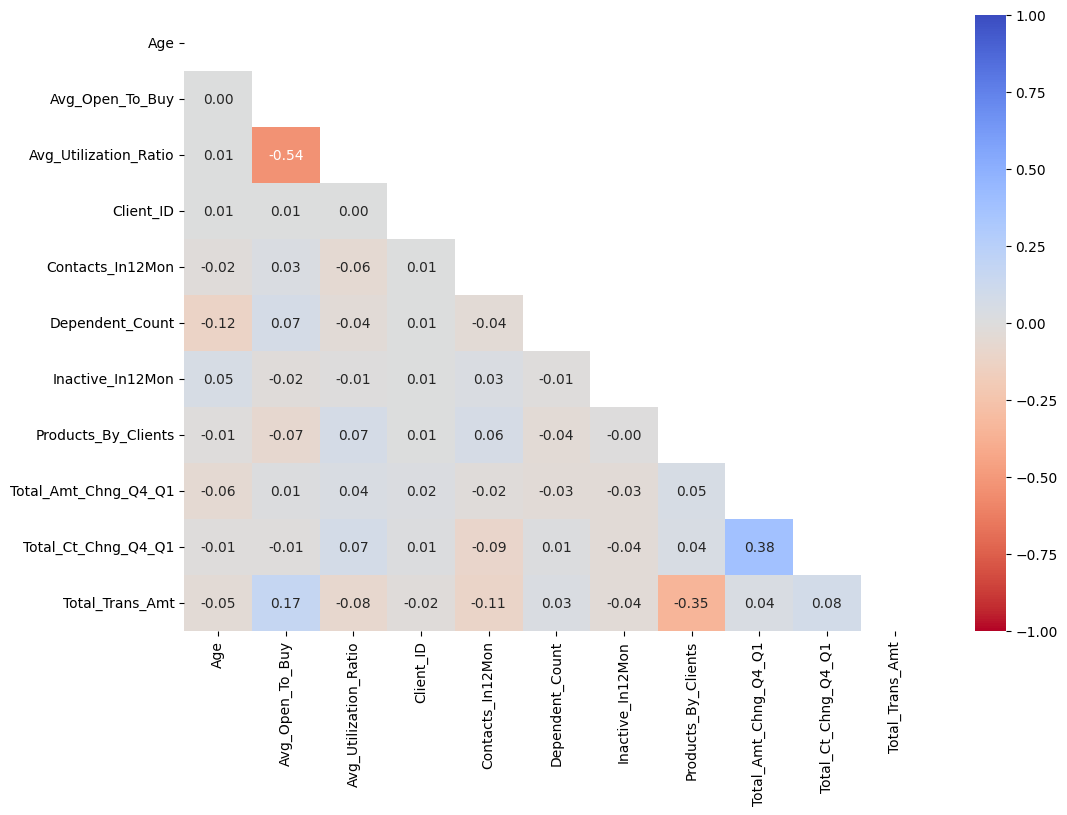

In [138]:
# Use the function to remove variables with high correlation
dropped_vars, new_churn_v2 = drop_highly_correlated(data=churn_df_full, threshold=0.7)

# Plot the correlation of the resulting data
corrPlot(data = new_churn_v2)

### $\color{blue}{\text{Removing Near Zero-Variance Variables}}$
- Some variables have little or no variation. They do not add much value to the model

In [139]:
from sklearn.feature_selection import VarianceThreshold

vThreshold = VarianceThreshold(threshold = 0.1)
vThreshold.fit_transform(new_churn_v2)

# Get variables with greater variance
vars = new_churn_v2.columns[vThreshold.get_support()]

# Subset data for variables with greater variance
churn_varDf = new_churn_v2[vars]

### $\color{blue}{\text{Standardization}}$

- To reduce the effect of outliers

In [140]:
from sklearn.preprocessing import StandardScaler

# Standardize data // comparing variables 'apples to apples'
churn_std = StandardScaler().fit_transform(churn_varDf)
# Transforms housing_std into a data frame and getting column names instead of numbers
churn_stdDf = pd.DataFrame(churn_std, columns = churn_varDf.columns)

# Bring the dependent variable to the standardized data // do NOT standardize dependent variable
churn_std_full = pd.concat([churn_stdDf, churn_df['Avg_Utilization_Ratio']], axis = 1)

### $\color{blue}{\text{Data Partitioning}}$

1. Identify dependent and independent variables
2. Partition the data such that 70% is used for training and 30% is used for testing

In [141]:
from sklearn.model_selection import train_test_split

# Independent variables used for regression
depVar = churn_std_full['Avg_Utilization_Ratio']
indVar = churn_std_full

# Partition data into training(70%) and testing(30%).
trainX, testX, trainY, testY = train_test_split(indVar, depVar, test_size = 0.3, random_state = 1)

## $\color{red}{\text{Linear Regression}}$

### $\color{blue}{\text{Multiple Linear Regression Model Training and Output}}$

### $\color{blue}{\text{Residual Analysis and QQ Plot for MLR}}$

- Residual Analysis and QQ-Plot

## $\color{red}{\text{Quantile Regression}}$

### $\color{blue}{\text{Quantile Regression Model and Output}}$

In [142]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Join all variables like a linear equation
equation = " + ".join(trainX.drop('Avg_Utilization_Ratio', axis = 1).columns)
# equation

# Let's form the regression equation
reg_formula = 'Avg_Utilization_Ratio ~ ' + equation
# reg_formula

# Build the quantile regression model
quant_reg = smf.quantreg(reg_formula, trainX).fit(0.9)

# Print results
print(quant_reg.summary())

                           QuantReg Regression Results                           
Dep. Variable:     Avg_Utilization_Ratio   Pseudo R-squared:               0.2730
Model:                          QuantReg   Bandwidth:                     0.05229
Method:                    Least Squares   Sparsity:                       0.6984
Date:                   Thu, 28 Mar 2024   No. Observations:                 7088
Time:                           22:30:50   Df Residuals:                     7079
                                           Df Model:                            8
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.5954      0.002    238.372      0.000       0.591       0.600
Age                     0.0008      0.003      0.322      0.747      -0.004       0.006
Avg_Open_To_Buy        -0.1960      0.004    -55.978      0.000      -0.20

### $\color{blue}{\text{Model Prediction}}$

- Predict the **Avg_Utilization_Ratio** of the testing data as a function of the independent variables

## $\color{red}{\text{Lasso Regression}}$


### $\color{blue}{\text{Model Fitting and Result}}$

In [156]:
# Add the intercept term to the data before modeling
trainX = sm.add_constant(trainX)

# LASSO modeling (As alpha increases, the coefficients shrink to zero. L1_wt = 1 means lasso regression)
# Alpha must yield a smaller error.
lasso_model = sm.OLS(trainY, trainX).fit_regularized(alpha = -20, L1_wt = 1)

# Print model coefficients
lasso_model.params

const                    169.051006
Age                       28.354529
Avg_Open_To_Buy         -106.442665
Client_ID                 20.824543
Contacts_In12Mon         -23.487414
Dependent_Count           24.531045
Inactive_In12Mon         -22.306241
Products_By_Clients       38.102842
Total_Trans_Amt           38.237403
Avg_Utilization_Ratio   -541.788276
dtype: float64

### $\color{blue}{\text{Model Prediction}}$

- Predict the **Avg_Utilization_Ratio** of the testing data as a function of the independent variables

In [157]:
# Always performed on testing data.
# Add the intercept term to the data before modeling
testX = sm.add_constant(testX)

# Predict housing prices based on testing data.
pred_test = lasso_model.predict(testX)

### $\color{blue}{\text{QQ Plot}}$

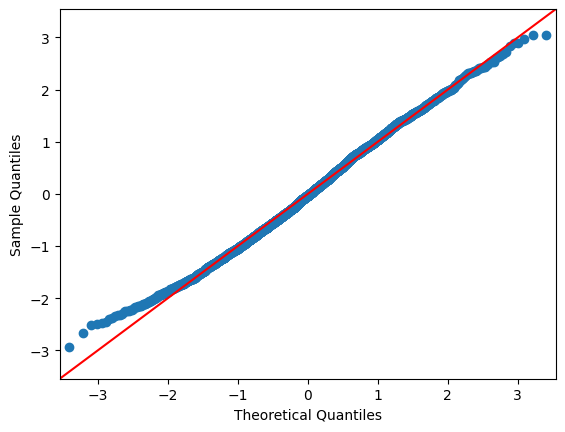

In [158]:
import scipy.stats as stats

residual = testY - pred_test
fig = sm.qqplot(residual, stats.t, fit = True, line = '45')
plt.show()

## $\color{red}{\text{Decision Tree and Random Forest Regression}}$

### $\color{blue}{\text{Model Fitting and Result}}$


In [20]:
# !pip install dmba
from dmba import plotDecisionTree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Create a decision tree and random forest model
dt_model = DecisionTreeRegressor(random_state = 100).fit(trainX, trainY)
rf_model = RandomForestRegressor(random_state = 100).fit(trainX, trainY)